# Deep Network Training

This notebook trains several neural networks to predict seabirds' dives from GPS data.

Dataset: Guany Cormorants trajectories sampled at 5, 15 and 30s

Network Architecture:

* FCNet : fully connected network (dense layer)
* CNNet : basic convolutional network
* UNet : U-Network with convolutional layers



## connect to drive

## data & libraries

In [1]:
#!pip install pandas

In [2]:
#!pip install pytorch_lightning

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
from utils.dataloader import *
from utils.model import *

In [5]:
data_train = pd.read_csv('./data/LB_train.csv')
data_validation = pd.read_csv('./data/LB_validation.csv')
data_test = pd.read_csv('./data/LB_test.csv')

## Dataset 5s


In [6]:
resolution = 5

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

/home/anupkumar/egalaxy/birdl/BirdDL/utils/dataloader.py:73: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  data_new = data_new.append(traj, ignore_index=True)
/home/anupkumar/egalaxy/birdl/BirdDL/utils/dataloader.py:65: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  traj['gaps'] = [np.mean(1*t.gaps[i:i+resolution]) for i in range(len(t)) if i%resolution==0]
/home/anupkumar/egalaxy/birdl/BirdDL/utils/dataloader.py:66: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `s

### FCNet

In [14]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5

train_set = TrajDataSet(train, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [18]:
train.shape

(67262, 13)

In [27]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

UsageError: Line magic function `%%time` not found.


In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('Tr = transform
ue Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

RuntimeError: Error(s) in loading state_dict for Lightning:
	Missing key(s) in state_dict: "model.cnn.2.weight", "model.cnn.2.bias", "model.cnn.8.weight", "model.cnn.8.bias". 
	Unexpected key(s) in state_dict: "model.cnn.9.weight", "model.cnn.9.bias", "model.cnn.1.weight", "model.cnn.1.bias", "model.cnn.1.running_mean", "model.cnn.1.running_var", "model.cnn.1.num_batches_tracked", "model.cnn.3.weight", "model.cnn.3.bias", "model.cnn.4.running_mean", "model.cnn.4.running_var", "model.cnn.4.num_batches_tracked", "model.cnn.7.weight", "model.cnn.7.bias", "model.cnn.7.running_mean", "model.cnn.7.running_var", "model.cnn.7.num_batches_tracked". 
	size mismatch for model.cnn.0.weight: copying a param with shape torch.Size([8, 3, 5]) from checkpoint, the shape in current model is torch.Size([100, 60]).
	size mismatch for model.cnn.0.bias: copying a param with shape torch.Size([8]) from checkpoint, the shape in current model is torch.Size([100]).
	size mismatch for model.cnn.4.weight: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([500, 500]).
	size mismatch for model.cnn.4.bias: copying a param with shape torch.Size([16]) from checkpoint, the shape in current model is torch.Size([500]).
	size mismatch for model.cnn.6.weight: copying a param with shape torch.Size([32, 16, 5]) from checkpoint, the shape in current model is torch.Size([500, 500]).
	size mismatch for model.cnn.6.bias: copying a param with shape torch.Size([32]) from checkpoint, the shape in current model is torch.Size([500]).

### CNNet

In [10]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5

class TrajDataSet_new():
    def __init__(self,  df, window, variable, transform=None):
        self.df = df.set_index(np.arange(len(df))) #reorder idx
        self.window = window
        self.var = variable
        self.start_idx = np.where([self.df.trip[i]==self.df.trip[i+self.window-1] for i in range(len(self.df)-self.window+1)])[0]
        self.transform = transform

    def __len__(self):
        return len(self.start_idx)

    def __getitem__(self, idx):
        i = self.start_idx[idx]
        # select variable of interest
        traj = self.df.loc[i:i+self.window-1, self.var]
        traj = np.array(traj).T
        dive = self.df.loc[i:i+self.window-1, 'dive']
        dive = np.array(dive)
        sample = (traj, dive)
        if self.transform:
            sample = self.transform(sample)
        print(sample[0].shape, sample[1].shape)
        
        return sample
    
    
def create_mat(data_set):
    d_features = list()
    d_labels = list()
    for i in range(len(data_set.start_idx)):
        row = data_set.__getitem__(i)
        #print(row[0].shape, row[1].shape)
        d_features.append(row[0].numpy())
        d_labels.append(row[1].numpy())
    d_features = np.array(d_features)
    d_labels = np.array(d_labels)
    print(d_features.shape)
    print(d_labels.shape)
    return d_features, d_labels

train_set = TrajDataSet_new(train, window, variable, transform=ToTensor())
tr_features, tr_labels = create_mat(train_set)

val_set = TrajDataSet_new(val, window, variable, transform=ToTensor())
val_features, val_labels = create_mat(val_set)
#train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

#val_set = TrajDataSet_new(val, window, variable, transform=ToTensor())
#val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

(66502, 3, 20)
(66502, 20)
(43063, 3, 20)
(43063, 20)


In [47]:
idx = 20
tr_features[idx], tr_labels[idx]

(array([[  19.27362   ,   18.31519   ,   16.952826  ,   19.466944  ,
           11.937635  ,   14.121091  ,   12.378998  ,    4.1418486 ,
            2.47161   ,    1.4849467 ,    0.7063133 ,    0.55827355,
            0.57047755,    0.8201955 ,    0.38941717,    0.34345785,
            0.5235044 ,    0.6291619 ,    0.37846187,    0.65724456],
        [   4.2170033 ,  -10.887347  ,   -9.568497  ,    2.6136427 ,
           -3.9791481 ,   -7.9242134 ,   -5.619147  ,  -57.127007  ,
          178.19043   ,    4.9865584 , -126.12624   ,  100.90675   ,
          111.90482   , -132.76207   ,  -58.957447  ,  -83.72119   ,
          118.39033   ,  -98.7079    ,  110.722565  ,  -95.83231   ],
        [   0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.2       ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.        ,    0.        ,    0.        ,
            0.        ,    0.   

In [43]:
import tensorflow as tf

model = tf.keras.models.Sequential([
    tf.keras.layers.Conv1D(8, kernel_size=5, padding='same', activation='relu', strides=1, data_format='channels_last', input_shape=(3, 20)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(16, kernel_size=5, padding='same', activation='relu', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(32, kernel_size=5, padding='same', activation='relu', strides=1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv1D(1, kernel_size=5, padding='same', strides=1),
])

model.compile(
    optimizer='adam',
    loss= 'binary_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_73 (Conv1D)          (None, 3, 8)              808       
                                                                 
 batch_normalization_54 (Bat  (None, 3, 8)             32        
 chNormalization)                                                
                                                                 
 conv1d_74 (Conv1D)          (None, 3, 16)             656       
                                                                 
 batch_normalization_55 (Bat  (None, 3, 16)            64        
 chNormalization)                                                
                                                                 
 conv1d_75 (Conv1D)          (None, 3, 32)             2592      
                                                                 
 batch_normalization_56 (Bat  (None, 3, 32)          

In [44]:
model.fit(tr_features, tr_labels, batch_size=32, validation_data=(val_features, val_labels), epochs=5)

Epoch 1/5


ValueError: in user code:

    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/engine/training.py", line 1160, in train_function  *
        return step_function(self, iterator)
    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/engine/training.py", line 1146, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/engine/training.py", line 1135, in run_step  **
        outputs = model.train_step(data)
    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/engine/training.py", line 994, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/engine/training.py", line 1052, in compute_loss
        return self.compiled_loss(
    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/engine/compile_utils.py", line 265, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/losses.py", line 152, in __call__
        losses = call_fn(y_true, y_pred)
    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/losses.py", line 272, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/losses.py", line 2162, in binary_crossentropy
        backend.binary_crossentropy(y_true, y_pred, from_logits=from_logits),
    File "/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/keras/backend.py", line 5685, in binary_crossentropy
        bce = target * tf.math.log(output + epsilon())

    ValueError: Dimensions must be equal, but are 20 and 3 for '{{node binary_crossentropy/mul}} = Mul[T=DT_FLOAT](IteratorGetNext:1, binary_crossentropy/Log)' with input shapes: [?,20], [?,3].


In [ ]:
## Model training
#%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+ str(resolution)+ 's--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = True)

trainer.fit(model, train_loader, val_loader)

/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:161: UserWarning: You passed `deterministic=True` and `benchmark=True`. Note that PyTorch ignores torch.backends.cudnn.deterministic=True when torch.backends.cudnn.benchmark=True.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:616: UserWarning: Checkpoint directory /home/anupkumar/egalaxy/birdl/BirdDL/results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")

  | Name  | Type  | Params
--------------------------------
0 | model | CNNet | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.015     Total estim

Sanity Checking: 0it [00:00, ?it/s]

/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
t

/home/anupkumar/anaconda3/envs/galaxye/lib/python3.10/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Epoch 0:   0%|                                                                                                                                  | 0/108 [00:00<?, ?it/s]torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]) torch.Size([20])
torch.Size([3, 20]

In [76]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
print(test)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

IsADirectoryError: [Errno 21] Is a directory: '/home/anupkumar/egalaxy/birdl/BirdDL'

### UNet

In [ ]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

In [ ]:
test.to_csv('./results/LB_'+str(resolution)+'s.csv', index = False)

## Dataset 15s


In [ ]:
resolution = 15

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

### FCNet

In [ ]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5
train_set = TrajDataSet(train, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### CNNet

In [ ]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5

train_set = TrajDataSet(train, window, variable, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model training
%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### UNet

In [ ]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

In [ ]:
test.to_csv('./results/LB_'+str(resolution)+'s.csv', index = False)

## Dataset 30s


In [ ]:
resolution = 30

train = format_data(data_train, resolution)
val = format_data(data_validation, resolution)
test = format_data(data_test, resolution)

### FCNet

In [ ]:
## Dataloader
window = 21
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5
train_set = TrajDataSet(train, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=transforms.Compose([Center(), ToTensor()]))
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model Training
%%time

model = Lightning(FCNet(window, len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 0,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)


trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1304: UserWarning: GPU available but not used. Set the gpus flag in your trainer `Trainer(gpus=1)` or script `--gpus=1`.
  "GPU available but not used. Set the gpus flag in your trainer"

  | Name  | Type  | Params
--------------------------------
0 | model | FCNet | 558 K 
--------------------------------
558 K     Trainable params
0         Non-trainable params
558 K     Total params
2.234     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 2min 3s, sys: 885 ms, total: 2min 4s
Wall time: 2min 3s


0.6541108421335606


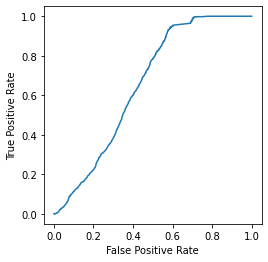

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=FCNet(window, len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['FCNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### CNNet

In [ ]:
## Dataloader
window = 20
variable = ('step_speed', 'step_direction', 'gaps')
batch_size = 1024
W = 5

train_set = TrajDataSet(train, window, variable, transform=ToTensor())
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle = True)

val_set = TrajDataSet(val, window, variable, transform=ToTensor())
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle = False)

In [ ]:
## Model training
%%time

model = Lightning(CNNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type  | Params
--------------------------------
0 | model | CNNet | 3.6 K 
--------------------------------
3.6 K     Trainable params
0         Non-trainable params
3.6 K     Total params
0.015     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 3min 14s, sys: 1.13 s, total: 3min 15s
Wall time: 3min 14s


0.743887586995305


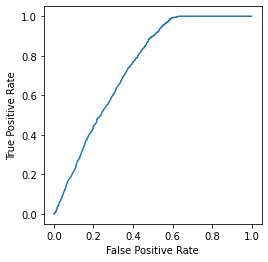

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=CNNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['CNNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

### UNet

In [ ]:
## Model training
%%time

model = Lightning(UNet(len(variable)), W)
earlystopping = EarlyStopping('val_loss')
modelcheckpoint = ModelCheckpoint(
    dirpath = './results',
    filename = 'LB_'+model.model.name+'_'+str(resolution)+'s--{epoch}-{val_loss:.2f}-{train_loss:.2f}',
    monitor = 'val_loss')

trainer = Trainer(max_epochs=20, progress_bar_refresh_rate=20, gpus = 1,
                  callbacks=[modelcheckpoint, earlystopping],
                  deterministic = True,
                  benchmark = True,
                  logger = False)

trainer.fit(model, train_loader, val_loader)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:446: UserWarning: Checkpoint directory ./results exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type | Params
-------------------------------
0 | model | UNet | 18.9 K
-------------------------------
18.9 K    Trainable params
0         Non-trainable params
18.9 K    Total params
0.076     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

CPU times: user 4min 21s, sys: 1.5 s, total: 4min 23s
Wall time: 4min 22s


0.8843939994623464


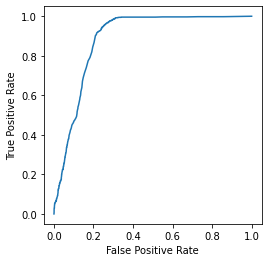

In [ ]:
## Model testing

model = Lightning.load_from_checkpoint(modelcheckpoint.best_model_path, model=UNet(len(variable)), weight = W)
model.eval()
test = model.predict(test, window, variable)
roc_x, roc_y = model.roc(test['UNet'], test['dive'])

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
plt.plot(roc_x, roc_y)
print(-np.trapz(roc_y, roc_x))

In [ ]:
test.to_csv('./results/LB_'+str(resolution)+'s.csv', index = False)